# Import Data #


In [64]:
import pandas as pd
pd.options.display.max_columns = 200

df = pd.read_csv('../data/spotify_clean.csv', index_col=[0])
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,j-pop
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Data Visualization #


* __get_numeric_features_distribution__ - shows distributions of all numeric features from provided dataframe. Flag _compare_with_normal_distribution_ is for comparison existing features' distributions with the normal distribution since Gaussian Naive Bayes assumes that features are normally distributed. For estimation of the feature distributions were chosen the following metrics:

1) _Kolmogorov-Smirnov (KS) test_ which assesses whether a sample comes from a specific distribution.
2) _P-value_, which indicates the probability of observing a KS statistic as extreme as the one computed from the sample, assuming the null hypothesis is true. Small p-value (< 0.05) indicates a significant difference between the sample and the specified distribution, Large p-value (> 0.05) suggests that there is no significant difference.

* __get_feature_distribution__ - shows distribution for the particular feature (track_genre by default)

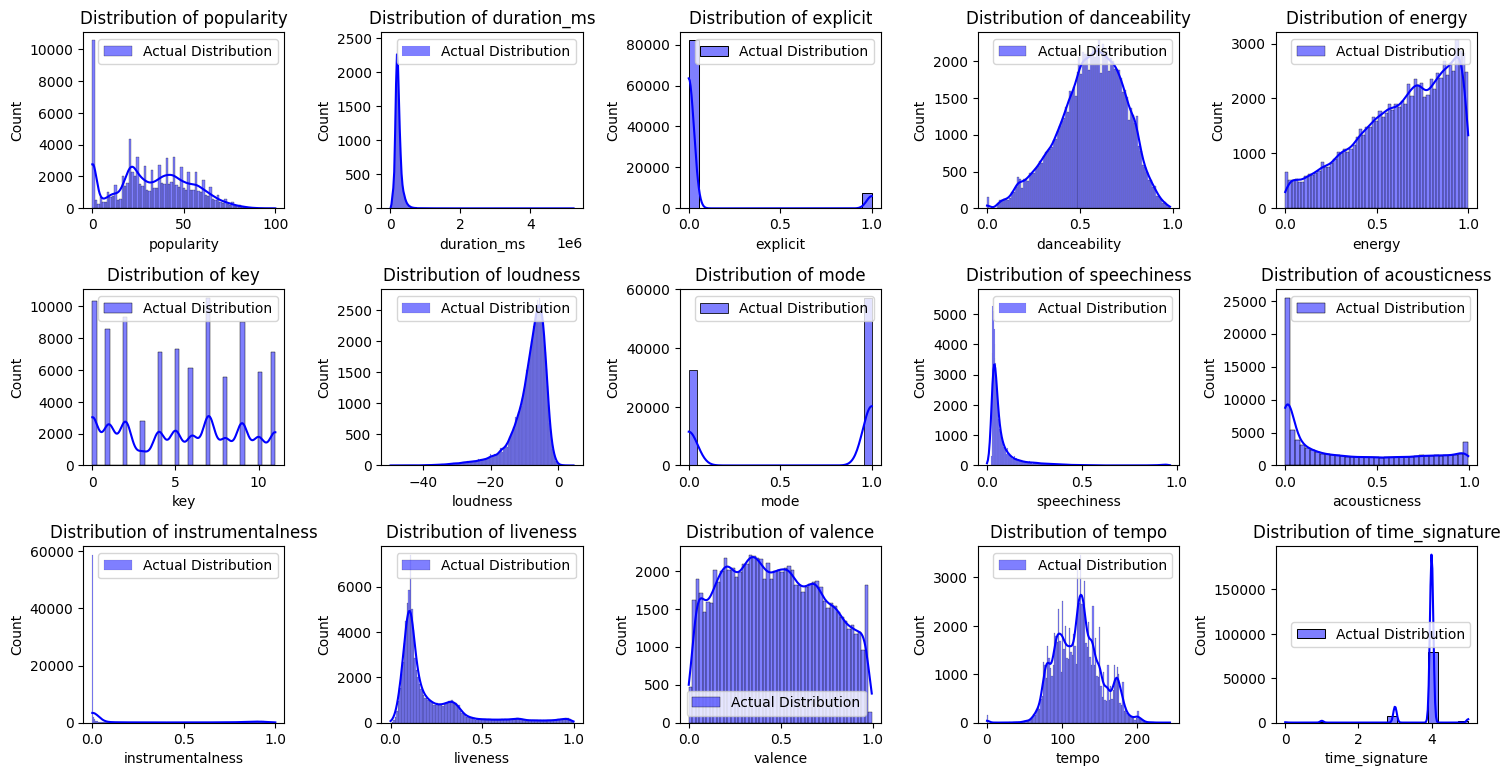

First 10 instances of 'track_genre':
0        j-pop
1     acoustic
2     acoustic
3     acoustic
4     acoustic
5    indie-pop
6     acoustic
7     acoustic
8     acoustic
9     acoustic
Name: track_genre, dtype: object

Value counts for 'track_genre':
track_genre
tango          1000
study           998
salsa           998
sleep           998
idm             996
               ... 
indie           361
alternative     317
reggae          310
latino          269
reggaeton       245
Name: count, Length: 114, dtype: int64


/var/folders/t3/h38q5w_d36ncdxty42rj79mr0000gn/T/ipykernel_2266/2223394977.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, fontsize=8)


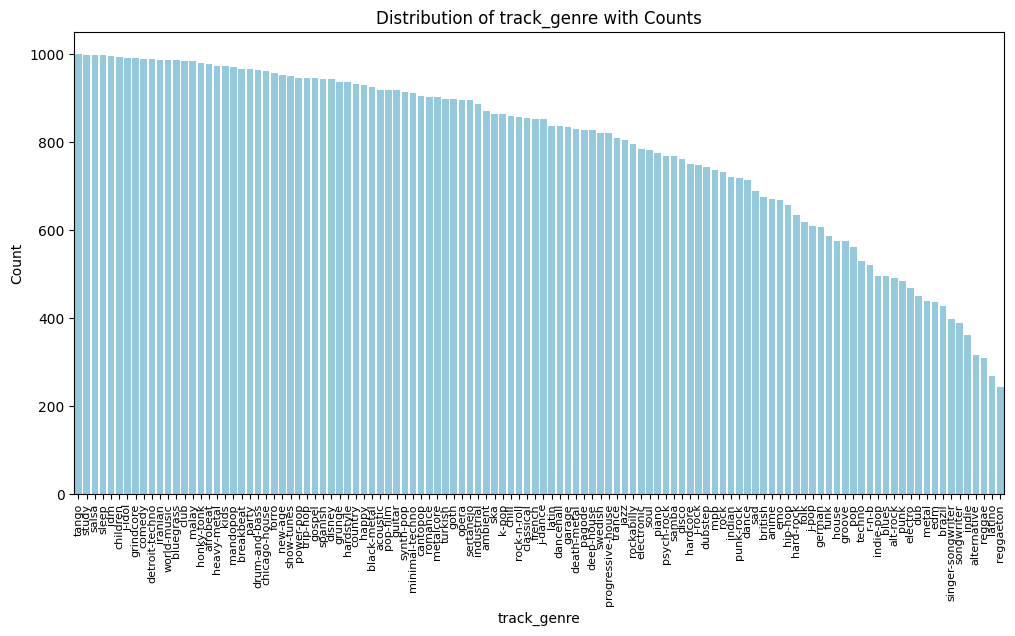

In [65]:
import numpy as np
from scipy.stats import norm, kstest
import seaborn as sns
import matplotlib.pyplot as plt

def get_numeric_features_distribution_info(df, compare_with_normal_distribution=False):
    # Select numeric features
    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

    # Set up the matplotlib figure for feature distributions
    plt.figure(figsize=(15, 10))

    # Create a dictionary to store KS statistics and p-values
    ks_results = {}

    for i, feature in enumerate(numeric_features, 1):
        # Plot histograms for each numeric feature
        plt.subplot(4, 5, i)
        sns.histplot(df[feature], kde=True, color='blue', label='Actual Distribution')

        if compare_with_normal_distribution:
            # Plot the normal distribution line
            mu, std = df[feature].mean(), df[feature].std()
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std)
            scale_factor = len(df[feature]) / len(x)
            plt.plot(x, p * scale_factor, 'y', linewidth=2, label='Normal Distribution')

            # Calculate metrics for comparison
            ks_statistic, ks_p_value = kstest(df[feature], 'norm', args=(mu, std))
            print(f"{feature} - KS Statistic: {ks_statistic}, KS P-Value: {ks_p_value}")

            # Store metrics in the dictionary
            ks_results[feature] = {'ks_statistic': ks_statistic, 'ks_p_value': ks_p_value}

        plt.title(f'Distribution of {feature}')
        plt.legend()

    plt.tight_layout()
    plt.show()

    return ks_results
    

def get_feature_distribution(df, target_column='track_genre'):
    # Display the first 10 instances of the target variable
    print(f"First 10 instances of '{target_column}':")
    print(df[target_column].head(10))

    # Display value counts for the target variable
    print(f"\nValue counts for '{target_column}':")
    print(df[target_column].value_counts())

    # Display the distribution of the target variable with counts on the y-axis
    value_counts = df[target_column].value_counts()

    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(x=value_counts.index, y=value_counts.values, color='skyblue')
    plt.title(f'Distribution of {target_column} with Counts')
    plt.xlabel(target_column)
    plt.ylabel('Count')

    # Rotate x-labels vertically and set font size
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, fontsize=8)

    plt.show()

get_numeric_features_distribution_info(df)
get_feature_distribution(df, target_column='track_genre')


# Data Understanding #

As __redundant__ and __irrelevant__ variables can decrease performance of the Naive Bayes, we will try to omit them. __Correlation matrix__ will help us to reveal redundant features (features with strong correlation)

Strongly correlated pairs of features and their correlation values:
energy and loudness: 0.7587736370436329


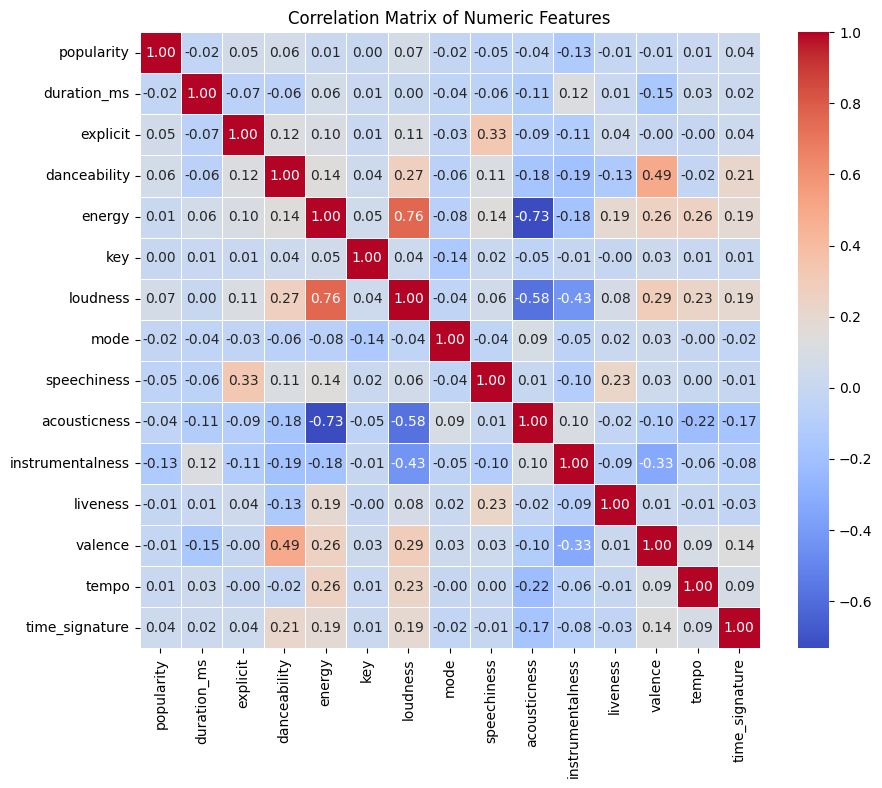

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix among numeric features
correlation_matrix = numeric_features.corr()

# Set the upper triangle of the correlation matrix (including the diagonal) to NaN
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find strongly correlated pairs of features (using a threshold, e.g., 0.5)
strongly_correlated_pairs = []
for i in range(len(upper_triangle.columns)):
    for j in range(i + 1, len(upper_triangle.columns)):
        if upper_triangle.iloc[i, j] > 0.5:
            feature_i, feature_j = upper_triangle.columns[i], upper_triangle.columns[j]
            correlation_value = upper_triangle.iloc[i, j]
            strongly_correlated_pairs.append((feature_i, feature_j, correlation_value))

# Display strongly correlated pairs and their correlation values
print("Strongly correlated pairs of features and their correlation values:")
for pair in strongly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()



# Data Preprocessing #


* From the strongly correlated pair of energy and loudness we will omit energy since it follows __normal distribution__ (main density function for Gaussian Naive Bayes) less than loudness feature. 

* __Drop__ irrelevant features for deriving the track genre like explicit feature (presence of the lyrics for the particular song) and etc.

* __Scale__ all remaining features via MinMaxScaler


popularity - KS Statistic: 0.05851342649986205, KS P-Value: 1.6000407230704606e-267
duration_ms - KS Statistic: 0.12934377302364408, KS P-Value: 0.0
danceability - KS Statistic: 0.032969198261809995, KS P-Value: 3.508549807346274e-85
loudness - KS Statistic: 0.12695424393206106, KS P-Value: 0.0
speechiness - KS Statistic: 0.2846894130870479, KS P-Value: 0.0
acousticness - KS Statistic: 0.16877837635752685, KS P-Value: 0.0
liveness - KS Statistic: 0.20139233775079568, KS P-Value: 0.0
valence - KS Statistic: 0.050083890699804956, KS P-Value: 4.52356774372742e-196
tempo - KS Statistic: 0.03792006127396036, KS P-Value: 1.4853210439282006e-112


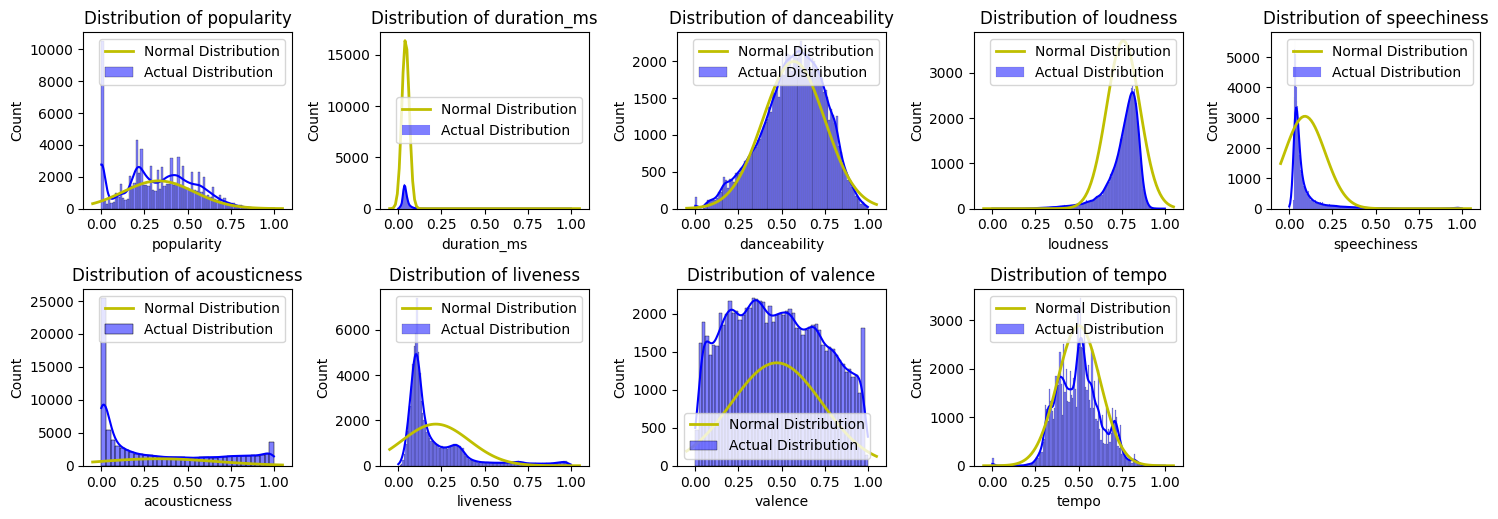

Average KS Statistic: 0.1211827467651681
Average KS P-Value: 3.8983886748291936e-86


In [67]:
from sklearn.preprocessing import MinMaxScaler

songs_df = df.drop(columns = ["track_id", "artists", "album_name", "track_name", "explicit", "key", "energy", "time_signature", "mode", "instrumentalness", "track_genre"])
genres = df["track_genre"]

# Assuming songs_df contains only numeric features
numeric_features = songs_df.columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the numeric features
songs_df[numeric_features] = scaler.fit_transform(songs_df[numeric_features])

distributions_info = get_numeric_features_distribution_info(songs_df, compare_with_normal_distribution=True)

average_ks_statistic = np.mean([entry['ks_statistic'] for entry in distributions_info.values()])
average_ks_p_value = np.mean([entry['ks_p_value'] for entry in distributions_info.values()])

print(f"Average KS Statistic: {average_ks_statistic}")
print(f"Average KS P-Value: {average_ks_p_value}")

# Parameter tuning #

Via cross validation we will try to calculate the best portion of the largest variance of all features that is added to variances for calculation stability (__var_smoothing__)

In [68]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV

# Split the data into features (X) and target variable (y)
X = songs_df
y = df['track_genre']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'var_smoothing': 1e-07}


# Model Training #

In [69]:
# Train the classifier with the best hyperparameters
best_nb_classifier = GaussianNB(var_smoothing=best_params['var_smoothing'])
best_nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_nb_classifier.predict(X_test)

# Model Evaluation #

In [70]:
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, predictions)
f1_weighted = f1_score(y_test, predictions, average='weighted')

# Print the results
print("Gaussian Naive Bayes Classifier Performance:")

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1_weighted}")

Gaussian Naive Bayes Classifier Performance:
Accuracy: 0.22537330064631156
F1-score: 0.18598322710352935


# Over/Under Sampling #

In [71]:
from sklearn.model_selection import  cross_val_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

# Define different sampling techniques
oversamplers = [RandomOverSampler(random_state=42), SMOTE(random_state=42)]
undersamplers = [RandomUnderSampler(random_state=42), NearMiss(version=1)]

# Loop through different oversampling techniques
for oversampler in oversamplers:
    # Define the pipeline with oversampling
    sampling_pipeline = Pipeline([
        ('oversampler', oversampler),
        ('classifier', best_nb_classifier)
    ])

    # Perform cross-validation with oversampling
    oversampling_scores = cross_val_score(sampling_pipeline, X_train, y_train, scoring='f1_weighted', cv=5)
    
    # Print the results
    print(f"Oversampling with {oversampler.__class__.__name__} scores:", oversampling_scores.mean())

# Loop through different undersampling techniques
for undersampler in undersamplers:
    # Define the pipeline with undersampling
    sampling_pipeline = Pipeline([
        ('undersampler', undersampler),
        ('classifier', best_nb_classifier)
    ])

    # Perform cross-validation with undersampling
    undersampling_scores = cross_val_score(sampling_pipeline, X_train, y_train, scoring='f1_weighted', cv=5)
    
    # Print the results
    print(f"Undersampling with {undersampler.__class__.__name__} scores:", undersampling_scores.mean())


Oversampling with RandomOverSampler scores: 0.1859745427867027
Oversampling with SMOTE scores: 0.18576544066479045
Undersampling with RandomUnderSampler scores: 0.18629894772978903
Undersampling with NearMiss scores: 0.13565331639315933


As we can see there is no reasonable improvements ;(